## Table of Content

1. Mounting GColab to GDrive.
2. Unzipping dataset files.
3. Extracting emotions from all the four sources.
4. Exploratory Data Analysis
5. Data Augmentation Techniques
6. Data Transformation and Modeling & Evaluation

## Mounting GColab to GDrive

In [1]:
# library to access GDrive
import glob
from google.colab import drive
import os
import sys

# Lbrary to unzip file
import zipfile

import pandas as pd
import numpy as np

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

import IPython.display as ipd

# import warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mountDrive():
  """
  This function will mount GColab with GDrive.
  Please click on the link to generate authorization code.
  """
  drive.mount("/content/drive")

mountDrive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Unzipping dataset files.

In [3]:
def unzipFile(fileName,toFolder):
  """
  All the four datasets are uploaded to personal GDrive account.
  Located @ "/content/drive/My Drive/Colab Notebooks/Audio Analysis/Data".
  """
  # !unzip "/content/drive/My Drive/Colab Notebooks/Audio Analysis/Data/325566_653195_bundle_archive.zip"

  # The code below is taken from stackoverflow.com.
  # https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook

  zip_ref = zipfile.ZipFile(f"/content/drive/My Drive/Colab Notebooks/Audio Analysis/Data/{fileName}", "r")
  zip_ref.extractall(f"/content/{toFolder}")
  zip_ref.close()
  print(f"{fileName} is unzipped.")


unzipFile("325566_653195_bundle_archive.zip", "Crema") # Crema Datase

unzipFile("107620_256618_bundle_archive.zip", "Ravdess") # Ravdess Dataset

unzipFile("338555_671851_bundle_archive.zip", "savee") # savee Dataset

unzipFile("316368_639622_bundle_archive.zip", "Tess") # TESS Dataset


325566_653195_bundle_archive.zip is unzipped.
107620_256618_bundle_archive.zip is unzipped.
338555_671851_bundle_archive.zip is unzipped.
316368_639622_bundle_archive.zip is unzipped.


## Extracting emotions from all the four sources.

In [4]:
def processing_cream(DS_path):
  """
  This funtion is responsible to process the cream data file. Here, the emotions and file locations are extracted.
  This function returns a DataFrame.
  """
  emotions = [] # to store list of emotion
  file_location = [] # to store file location

  data = os.listdir(DS_path)

  for item in data:
    file_location.append(DS_path + "/" + item)
    # print(item)

    # Extracting type of emotion from the file name
    # e.g. "1005_TIE_ANG_XX.wav" - file name
    # The code below will split the file name (string) into parts
    # At 3rd position lies the emotion type

    substr = item.split("_")
    substr = substr[2]
    if substr == 'NEU':
      emotions.append('Neutral')
    elif substr == 'ANG':
      emotions.append('Angry')
    elif substr == 'HAP':
      emotions.append('Happy')
    elif substr == 'FEA':
      emotions.append('Fear')
    elif substr == 'DIS':
      emotions.append('Disgust')
    elif substr == 'SAD':
      emotions.append('Sad')
    else:
      emotions.append('Unknown')

  data = pd.DataFrame(list(zip(emotions, file_location)), columns = ["Emotions", "File Location"])
  
  return data

def processing_ravdess(DS_path):
  """
  This funtion is responsible to process the Ravdess data file. Here, the emotions and file locations are extracted.
  This function returns a DataFrame.
  Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
  """

  emotions = [] # to store list of emotion
  file_location = [] # to store file location
  data = os.listdir(DS_path)

  for sub_folder in data:
    actor = os.listdir(DS_path + "/" + sub_folder)
    # print(actor)

    for item in actor:
      # Extracting type of emotion from the file name
      # e.g. "03-01-05-02-02-01-02.WAV" - file name
      # The code below will split the file name (string) into parts
      # At 3rd position lies the emotion type

      substr = (item.split('.')[0]).split("-")
      # print(substr)

      emotions.append(int(substr[2]))
      file_location.append(DS_path + "/" + sub_folder + "/" + item)

  data = pd.DataFrame(list(zip(emotions, file_location)), columns = ["Emotions", "File Location"])

  # changing integers to actual emotions.
  data.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)
  
  return data

def processing_savee(DS_path):
  """
  This funtion is responsible to process the Savee data file. Here, the emotions and file locations are extracted.
  This function returns a DataFrame.
  """
  emotions = [] # to store list of emotion
  file_location = [] # to store file location
  data = os.listdir(DS_path)

  for item in data:
    # print(item)
    file_location.append(DS_path + "/" + item)

    # Extracting type of emotion from the file name
    # e.g. "03-01-05-02-02-01-02.WAV" - file name
    # The code below will split the file name (string) into parts

    substr = item.split("_")[1]
    substr = substr[:-6]
    if substr == 'a':
        emotions.append('Angry')
    elif substr == 'd':
        emotions.append('Disgust')
    elif substr == 'f':
        emotions.append('Fear')
    elif substr == 'h':
        emotions.append('Happy')
    elif substr == 'n':
        emotions.append('Neutral')
    elif substr == 'sa':
        emotions.append('Sad')
    else:
        emotions.append('Surprise')

  data = pd.DataFrame(list(zip(emotions, file_location)), columns = ["Emotions", "File Location"])
  
  return data

def processing_tess(DS_path):
  """
  This funtion is responsible to process the Tess data file. Here, the emotions and file locations are extracted.
  This function returns a DataFrame.
  """
  emotions = [] # to store list of emotion
  file_location = [] # to store file location
  data = os.listdir(DS_path)

  for sub_folder in data:
    folder = os.listdir(DS_path + "/" + sub_folder)
    for item in folder:
      # print(item)
      file_location.append(DS_path + "/" + sub_folder + '/' + item)

      # Extracting type of emotion from the file name
      # e.g. "OA_bite_neutral.WAV" - file name
      # The code below will split the file name (string) into parts
      # At 3rd position lies the emotion type
      substr = (item.split("."))[0].split("_")
      substr = substr[2]
      if substr == 'ps':
        emotions.append('Surprise')
      else:
        emotions.append(substr.capitalize() )

  data = pd.DataFrame(list(zip(emotions, file_location)), columns = ["Emotions", "File Location"])
  
  return data


In [5]:
# dataset path location 
crema_path = "Crema/AudioWAV"
ravdess_path = "Ravdess/audio_speech_actors_01-24"
savee_path = "savee/ALL"
tess_path = "Tess/TESS Toronto emotional speech set data"

ravdess_data = processing_ravdess(ravdess_path)
tess_data = processing_tess(tess_path)
savee_data = processing_savee(savee_path)
crema_data = processing_cream(crema_path)

In [6]:
#### trial code
# data = pd.concat([ravdess_data], axis = 0, ignore_index=True)
##### ends

# Merging all the separate dataframe into one dataframe
data = pd.concat([ravdess_data, tess_data, savee_data, crema_data], axis = 0, ignore_index=True)
data.head()

# Converting dataframe to CSV for future requirement
data.to_csv("data.csv",index=False)

In [7]:
data.head()

,Emotions,File Location
0,Happy,Ravdess/audio_speech_actors_01-24/Actor_09/03-...
1,Surprise,Ravdess/audio_speech_actors_01-24/Actor_09/03-...
2,Calm,Ravdess/audio_speech_actors_01-24/Actor_09/03-...
3,Disgust,Ravdess/audio_speech_actors_01-24/Actor_09/03-...
4,Surprise,Ravdess/audio_speech_actors_01-24/Actor_09/03-...


# Exploratory Data Analysis

  In this section we will see how each emotions can be represented and analysed.

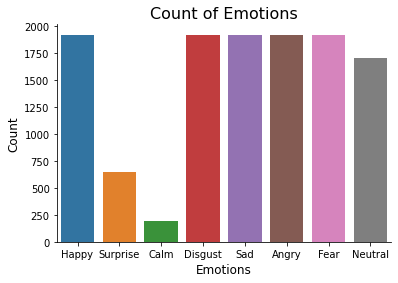

'\nRecord count for "Surprise" and "Calm" are comparatively less than the rest of the emotions\n'

In [8]:
# The distribution of emotions in the dataset

plt.title('Count of Emotions', size=16)
sns.countplot(data.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

"""
Record count for "Surprise" and "Calm" are comparatively less than the rest of the emotions
"""

In [9]:
# Different spectral representations of an audio signal.

def plotGraph(df, emotion, waveplot=False, spectrogram=False, melSpectrogram=False, mfcc=False, cqt=False, chromagram=False):
  file_location = np.array(df["File Location"][df.Emotions == emotion])[1]
  feature, sampling_rate = librosa.load(file_location)
  # print(sampling_rate)
  # stft function converts the data into short term fourier transform
  X = librosa.stft(feature)

  """
  Note: Below part of the code is understood and referred from https://musicinformationretrieval.com/mfcc.html 
  """

  if waveplot:
    """
    An audio signal is a representation of sound that represents the fluctuation in air pressure.
    """
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveplot(feature, sr=sampling_rate)
    plt.show()

  if spectrogram:
    """
    The spectrogram shows the the intensity of frequencies over time.
    """   
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()

  if melSpectrogram:
    """
    A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.
    """
    hop_length = 256
    S = librosa.feature.melspectrogram(feature, sr=sampling_rate, n_fft=4096, hop_length=hop_length)
    logS = librosa.power_to_db(abs(S))
    plt.figure(figsize=(12, 3))
    plt.title(f'melSpectrogram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(logS, sr=sampling_rate, x_axis='time', y_axis='mel')
    plt.colorbar()
  
  if mfcc:
    """
    The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope.
    """
    mfcc = librosa.feature.mfcc(feature, sr=sampling_rate, n_mfcc=13)
    plt.figure(figsize=(12, 3))
    plt.title(f'MFCC for audio with {emotion} emotion', size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

  if cqt:
    """
    Unlike the Fourier transform, 
    but similar to the mel scale, the constant-Q transform uses a logarithmically spaced frequency axis
    """
    fmin = librosa.midi_to_hz(36)
    C = librosa.cqt(feature, sr=sampling_rate, fmin=fmin, n_bins=72)
    logC = librosa.amplitude_to_db(abs(C))
    plt.figure(figsize=(12, 3))
    plt.title(f'constant-Q transform for audio with {emotion} emotion', size=15)
    librosa.display.specshow(logC, sr=sampling_rate, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
    plt.colorbar()

  if chromagram:
    """
    """
    hop_length = 256
    chromagram = librosa.feature.chroma_stft(feature, sr=sampling_rate, hop_length=hop_length)
    plt.figure(figsize=(15, 5))
    plt.title(f'chromagram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.colorbar()

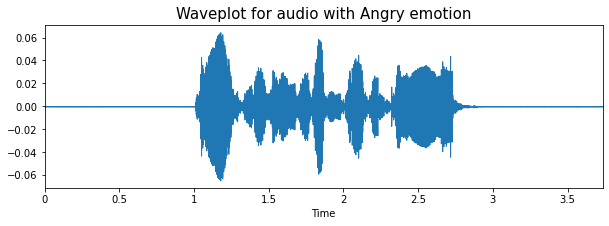

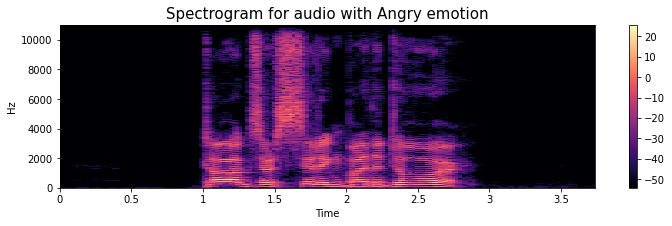

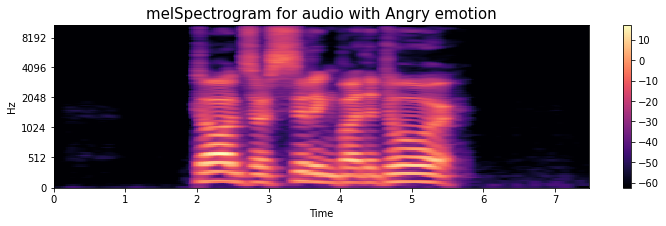

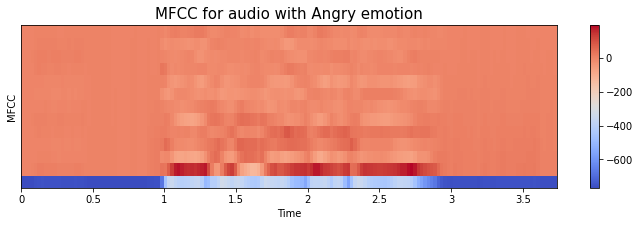

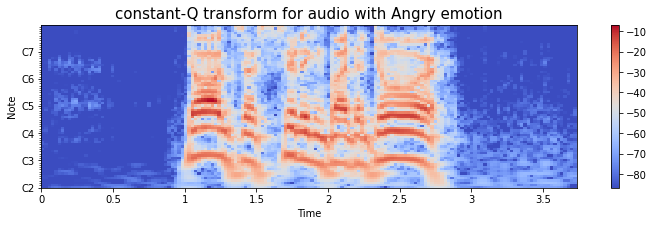

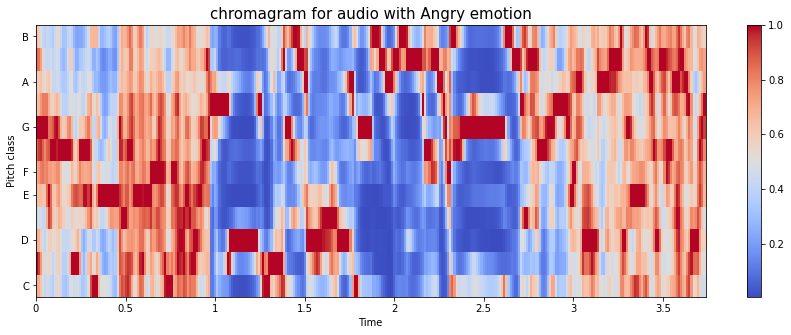

In [10]:
plotGraph(data, "Angry", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

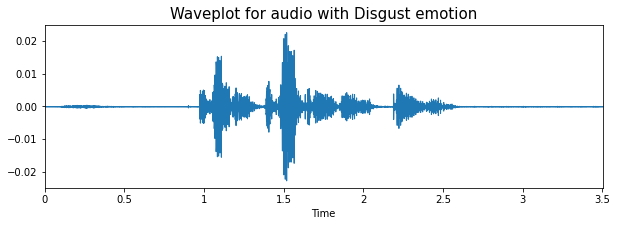

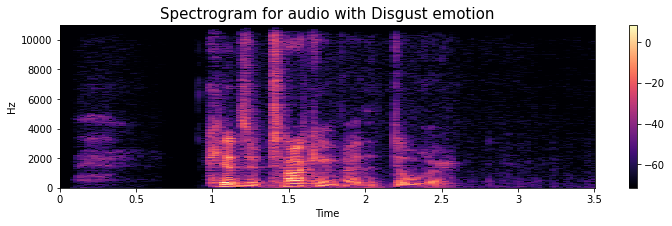

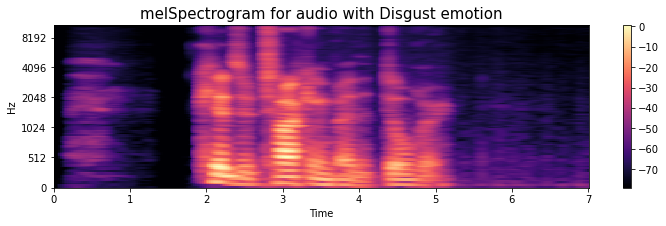

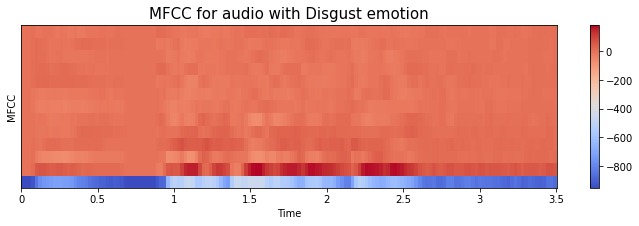

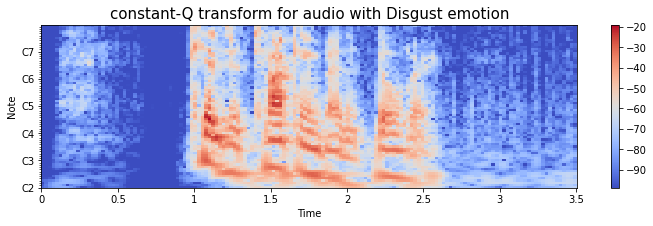

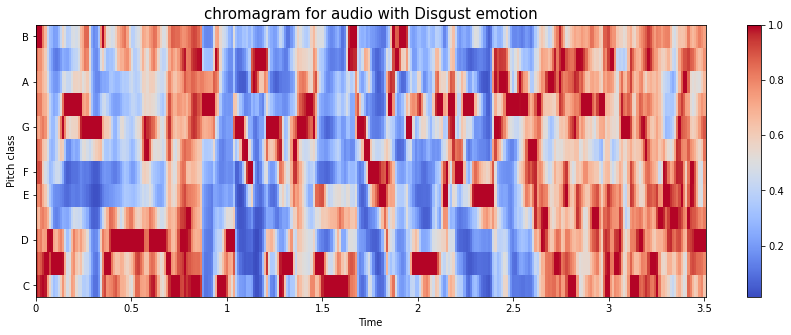

In [11]:
plotGraph(data, "Disgust", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

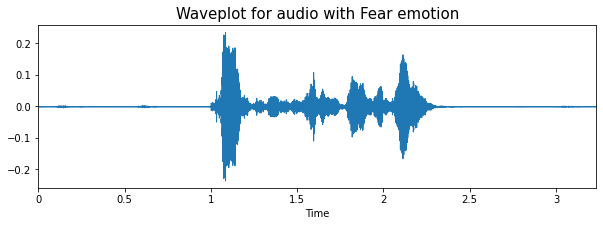

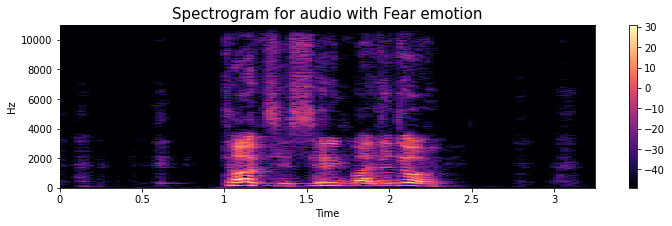

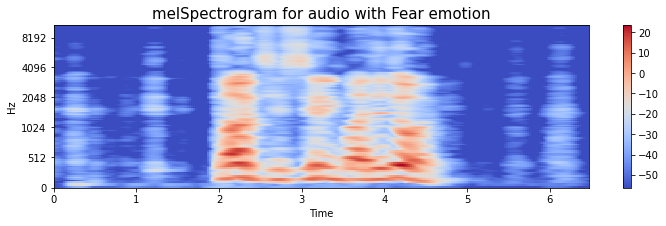

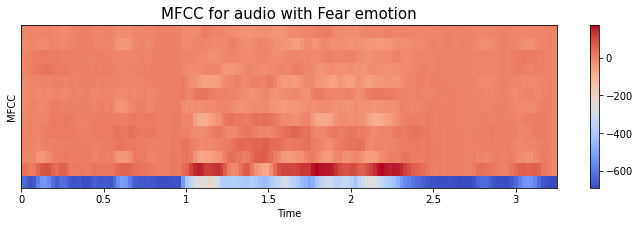

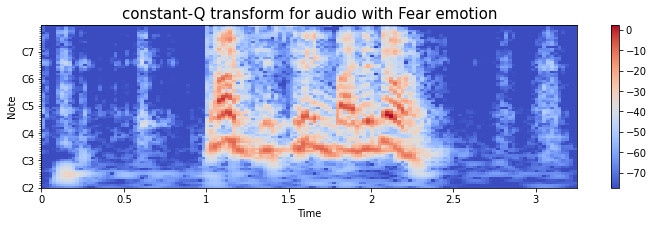

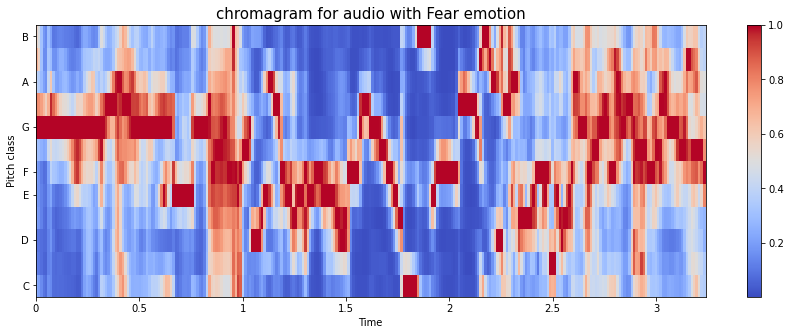

In [12]:
plotGraph(data, "Fear", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

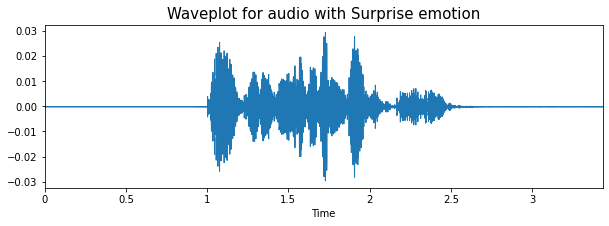

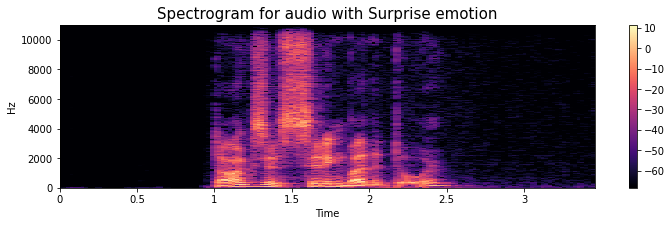

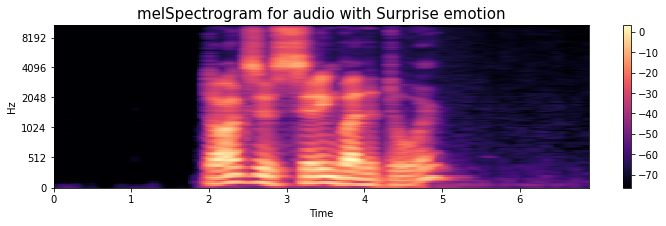

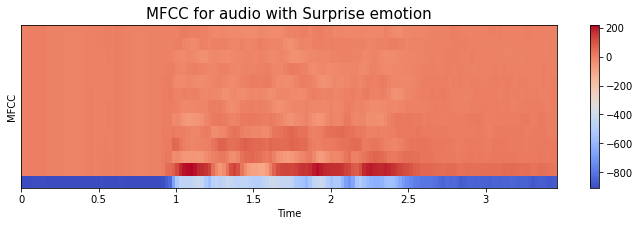

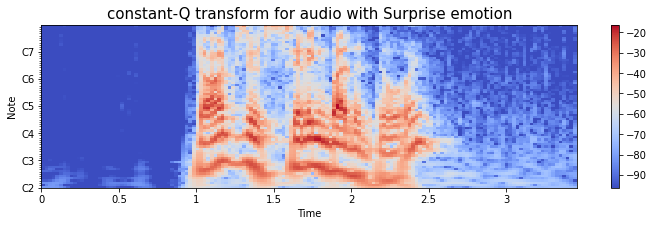

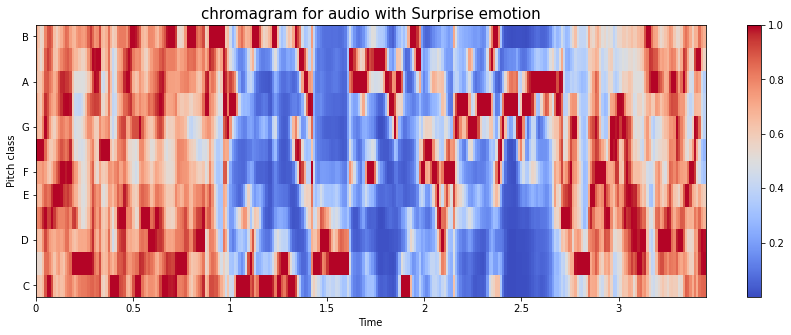

In [13]:
plotGraph(data, "Surprise", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

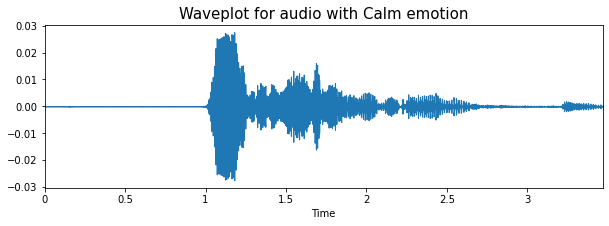

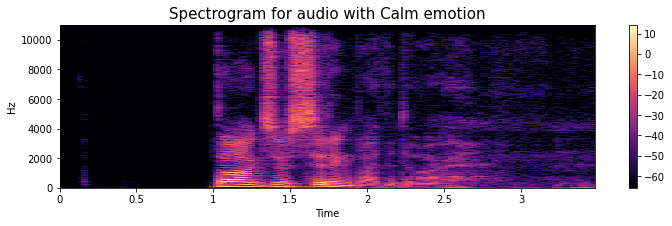

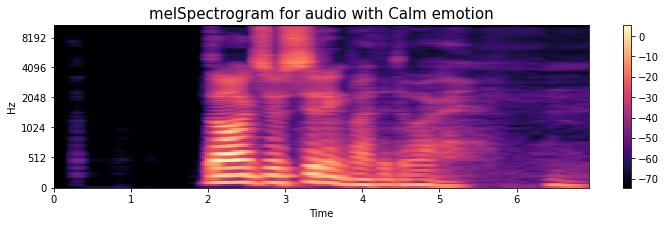

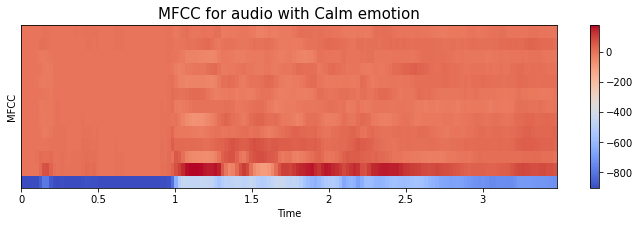

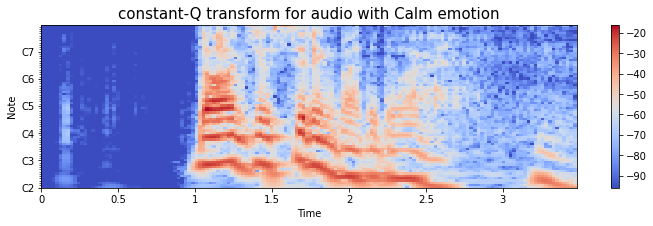

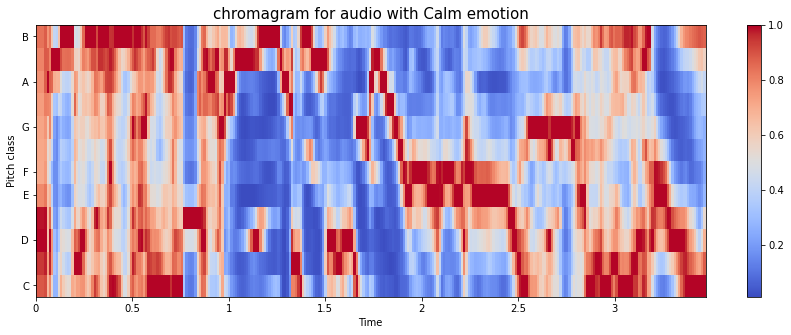

In [14]:
plotGraph(data, "Calm", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

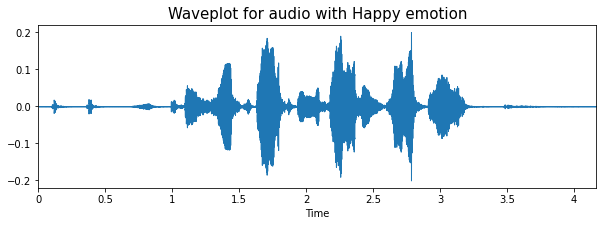

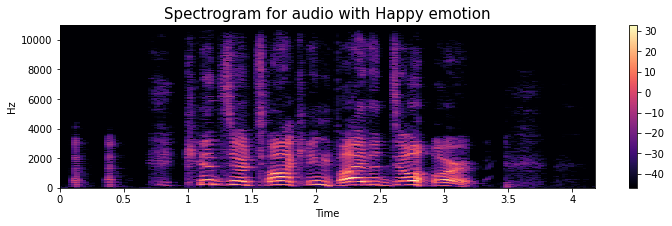

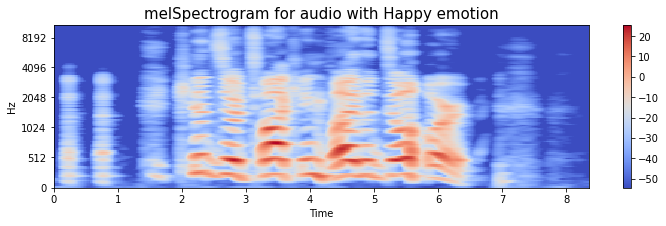

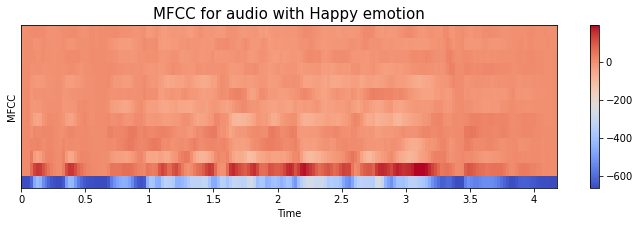

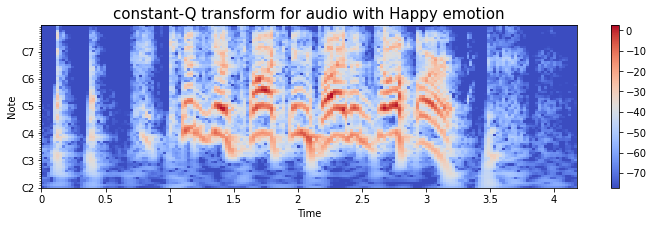

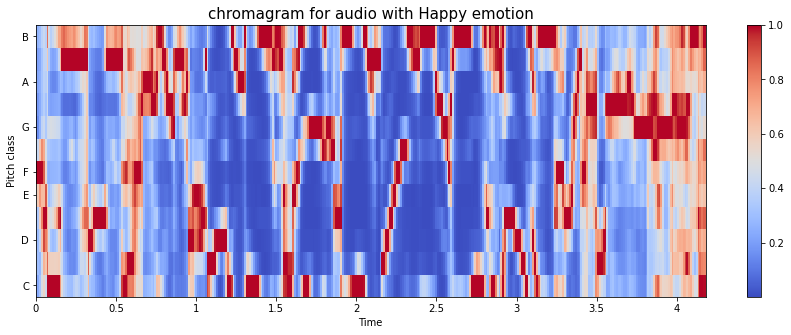

In [15]:
plotGraph(data, "Happy", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

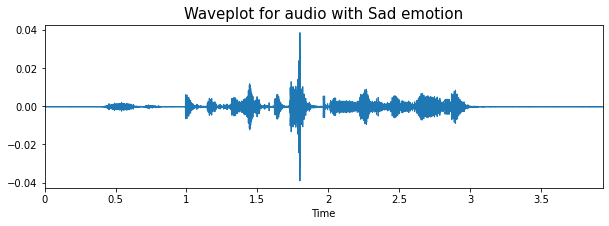

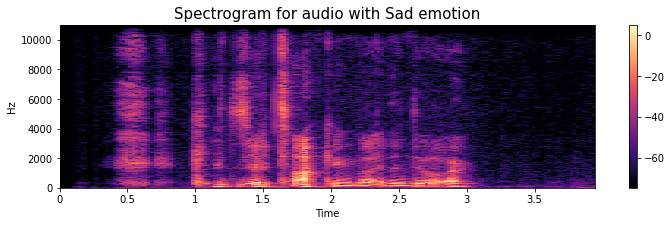

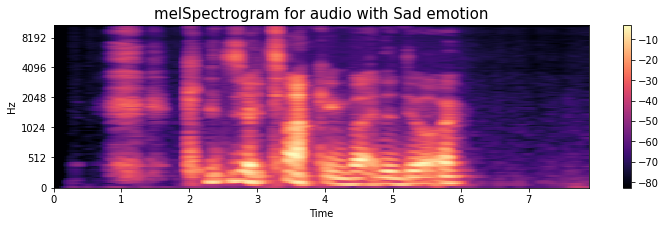

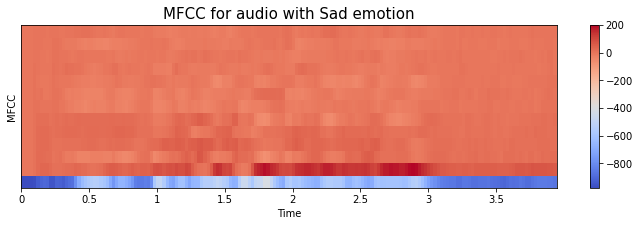

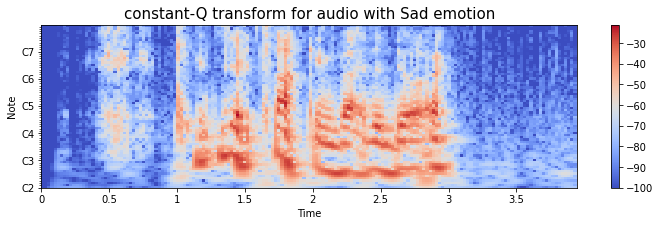

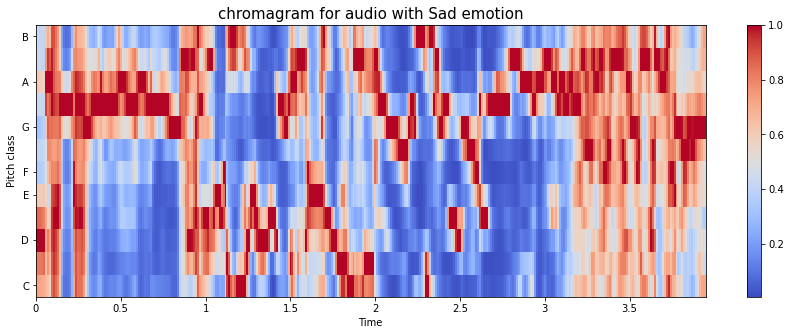

In [16]:
plotGraph(data, "Sad", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

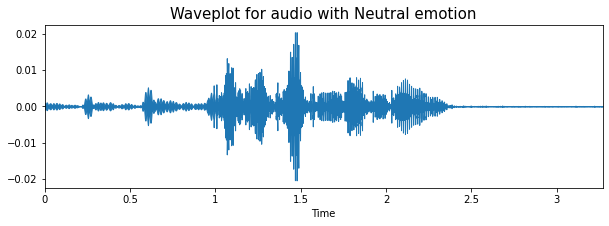

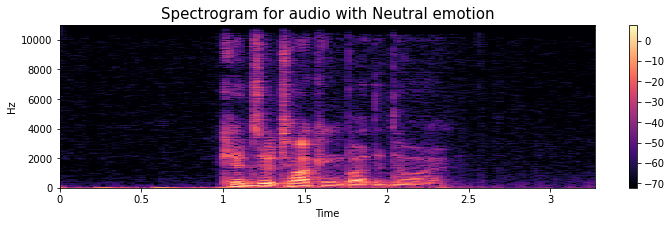

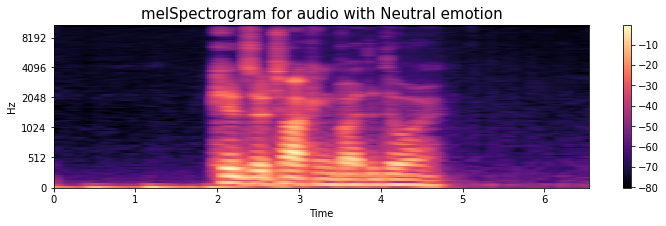

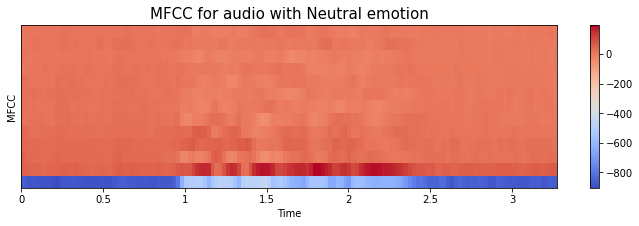

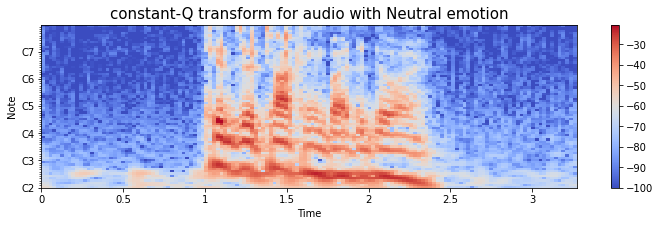

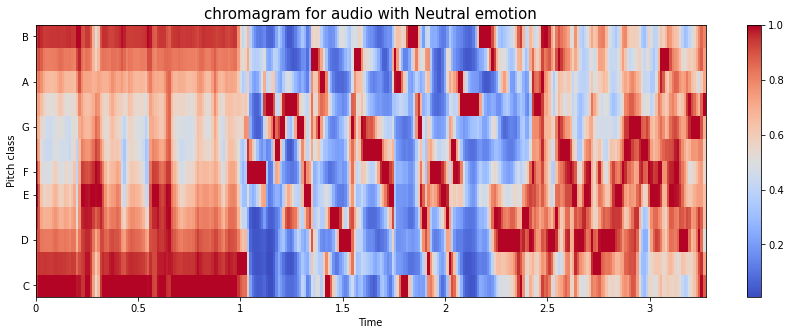

In [17]:
plotGraph(data, "Neutral", waveplot=True, spectrogram=True, melSpectrogram=True, mfcc=True, cqt=True, chromagram=True)

# Data Augmentation Techniques
  In this section we will see how and what data augmentation techniques are available

In [18]:
def dataAug(df, emotion, noise=False, stretch=False, shift=False, pitch=False):
  file_location = np.array(df["File Location"][df.Emotions == emotion])[2]
  feature, sampling_rate = librosa.load(file_location)
  plt.figure(figsize=(12,3))
  librosa.display.waveplot(y=feature, sr=sampling_rate)
  plt.title(f'Wavepot for audio with {emotion} emotion', size=15)
  # ipd.display(ipd.Audio(file_location))

  if noise:
    temp = feature
    noise_amp = 0.035*np.random.uniform()*np.amax(temp)
    temp = temp + noise_amp*np.random.normal(size=temp.shape[0])
    plt.figure(figsize=(12,3))
    librosa.display.waveplot(y=temp, sr=sampling_rate)
    plt.title(f'Wavepot for audio with {emotion} emotion with noise', size=15)
    # ipd.display(ipd.Audio(temp,rate=sampling_rate))

  if stretch:
    temp = feature
    rate = 0.8
    plt.figure(figsize=(12,3))
    x = librosa.effects.time_stretch(temp, rate)
    librosa.display.waveplot(y=x, sr=sampling_rate)
    plt.title(f'Wavepot for audio with {emotion} emotion with stretch', size=15)
    # ipd.display(ipd.Audio(x,rate=sampling_rate))

  if shift:
    temp = feature
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    plt.figure(figsize=(12,3))
    x = np.roll(temp, shift_range)
    librosa.display.waveplot(y=x, sr=sampling_rate)
    plt.title(f'Wavepot for audio with {emotion} emotion with shift', size=15)
    # ipd.display(ipd.Audio(x,rate=sampling_rate))

  if pitch:
    temp = feature
    pitch_factor = 0.7
    plt.figure(figsize=(12,3))
    x = librosa.effects.pitch_shift(temp, sampling_rate, pitch_factor)
    librosa.display.waveplot(y=x, sr=sampling_rate)
    plt.title(f'Wavepot for audio with {emotion} emotion with pitch', size=15)
    # ipd.display(ipd.Audio(x,rate=sampling_rate))

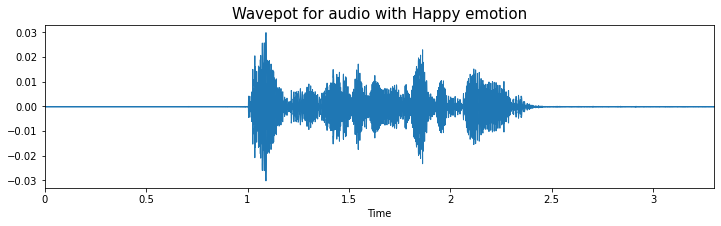

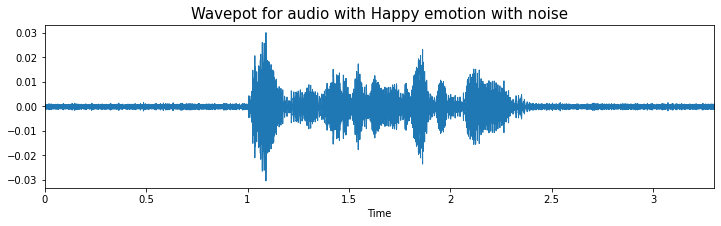

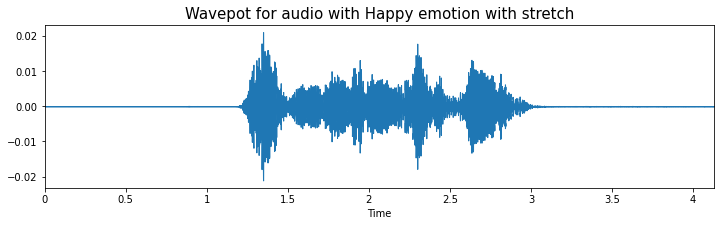

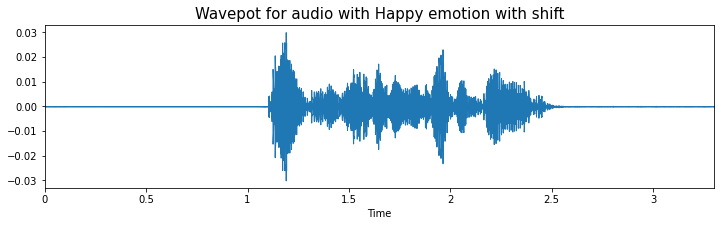

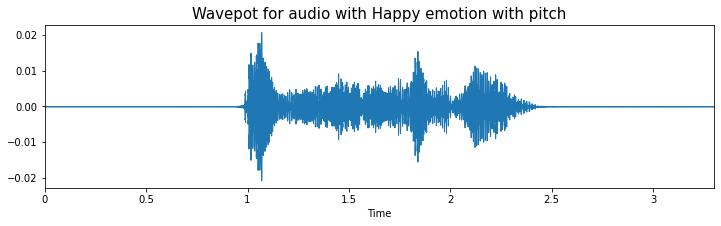

In [19]:
dataAug(data, "Happy", pitch=True, noise=True, stretch=True, shift=True)

# Data Transformation and Modeling & Evaluation
  In this step we will extract the features from an audio signal and do data augmentation.

In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def extract_features(data, sr):
    # Zero crossing rate 
    # provides 1 features
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma Vector
    # provides 12 features
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    # provides 20 features
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # # Root Mean Square Value
    # provides 1 features
    # rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    # result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    # provides 128 features
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

def CNN_model(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=16, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=8, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  return model
  
def data_transformation():

  X, Y = [], [] # two empty list to store features and emotion label
  for path, emotion in zip(data["File Location"], data.Emotions):
    feature = get_features(path)
    for sublist in feature:
      X.append(sublist) # X store the features
      Y.append(emotion) # Y stores the type of emotion label
  
  # len(X), len(Y)

  Features = pd.DataFrame(X) # creating a new df
  Features['labels'] = Y
  # Features.to_csv('features.csv', index=False) # converting df to csv for future reference

  X = Features.iloc[: ,:-1].values
  Y = Features['labels'].values

  encoder = OneHotEncoder()
  Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray() # This creates a binary column for each emotion label

  # splitting data
  x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True) # 75:25 split
  # x_train.shape, y_train.shape, x_test.shape, y_test.shape

  scaler = StandardScaler() # StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)
  # x_train.shape, y_train.shape, x_test.shape, y_test.shape

  # making our data compatible to model.
  x_train = np.expand_dims(x_train, axis=2)
  x_test = np.expand_dims(x_test, axis=2)
  # x_train.shape, y_train.shape, x_test.shape, y_test.shape

  model = CNN_model(x_train)
  # model.summary()

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[callback])

  return history, model, x_train, y_train, x_test, y_test, encoder

def evaluation(model, x_test, y_test):  
  
  print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
  epochs = [i for i in range(50)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  test_acc = history.history['val_accuracy']
  test_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

def predit(model, x_test, y_test, encoder):
  # predicting on test data.
  pred_test = model.predict(x_test)
  y_pred = encoder.inverse_transform(pred_test)

  y_true = encoder.inverse_transform(y_test)
  df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
  df['Predicted Labels'] = y_pred.flatten()
  df['Actual Labels'] = y_true.flatten()

  print(df.head(5))

  return pred_test, y_pred, y_true

def confusionMatrix(encoder, y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize = (12, 10))
  cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
  sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix', size=20)
  plt.xlabel('Predicted Labels', size=14)
  plt.ylabel('Actual Labels', size=14)
  plt.show()

  print(classification_report(y_true, y_pred))

In [21]:
# X, Y = [], []
# for path, emotion in zip(data["File Location"], data.Emotions):
#   feature = get_features(path)
#   for sublist in feature:
#     X.append(sublist)
#     # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#     Y.append(emotion)
# len(X), len(Y), data["File Location"].shape

In [22]:
history, model, x_train, y_train, x_test, y_test, encoder = data_transformation()

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Epoch 1/50
428/428 [==============================] - 175s 409ms/step - loss: 1.8134 - accuracy: 0.2585 - val_loss: 1.6477 - val_accuracy: 0.3463
Epoch 2/50
428/428 [==============================] - 174s 407ms/step - loss: 1.5894 - accuracy: 0.3577 - val_loss: 1.4431 - val_accuracy: 0.4325
Epoch 3/50
428/428 [==============================] - 177s 413ms/step - loss: 1.4990 - accuracy: 0.4015 - val_loss: 1.4009 - val_accuracy: 0.4385
Epoch 4/50
428/428 [==============================] - 177s 413ms/step - loss: 1.4510 - accuracy: 0.4246 - val_loss: 1.3519 - val_accuracy: 0.4707
Epoch 5/50
428/428 [==============================] - 174s 407ms/step - loss: 1.4149 - accuracy: 0.4356 - val_loss: 1.3302 - val_accuracy: 0.4861
Epoch 6/50
428/428 [==============================] - 173s 403ms/step - loss: 1.3832 - accuracy: 0.4488 - val_loss: 1.3012 - val_accuracy: 0.4906
Epoch 7/50
428/428 [==============================] - 172s 403ms/step - loss: 1.3565 - accuracy: 0.4647 - val_loss: 1.2771 -

286/286 [==============================] - 13s 44ms/step - loss: 1.1605 - accuracy: 0.5773
Accuracy of our model on test data :  57.72857069969177 %


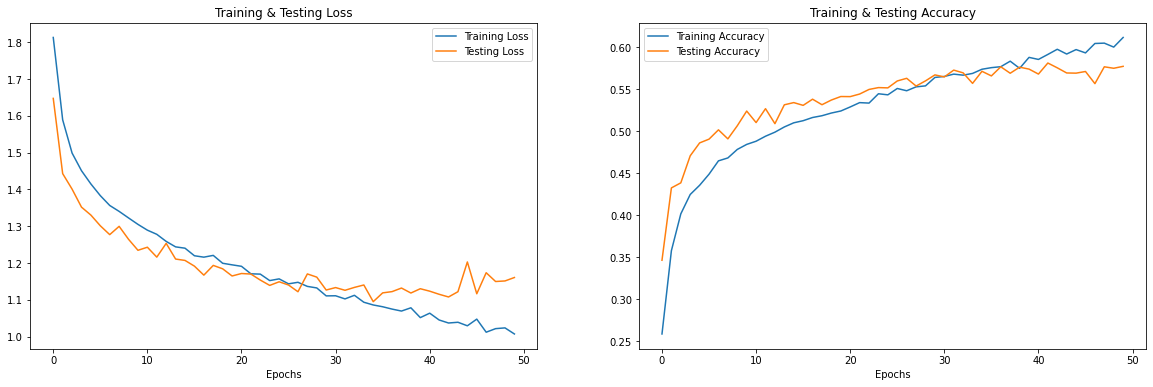

In [23]:
evaluation(model, x_test, y_test)

In [24]:
pred_test, y_pred, y_true = predit(model, x_test, y_test, encoder)

  Predicted Labels Actual Labels
0             Fear          Fear
1          Neutral       Neutral
2            Angry         Angry
3          Neutral       Neutral
4          Disgust       Disgust


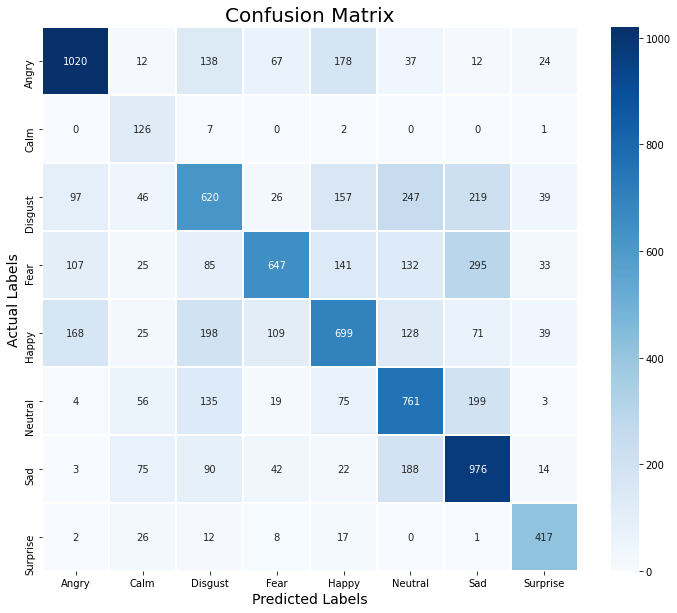

              precision    recall  f1-score   support

       Angry       0.73      0.69      0.71      1488
        Calm       0.32      0.93      0.48       136
     Disgust       0.48      0.43      0.45      1451
        Fear       0.70      0.44      0.54      1465
       Happy       0.54      0.49      0.51      1437
     Neutral       0.51      0.61      0.55      1252
         Sad       0.55      0.69      0.61      1410
    Surprise       0.73      0.86      0.79       483

    accuracy                           0.58      9122
   macro avg       0.57      0.64      0.58      9122
weighted avg       0.59      0.58      0.58      9122



In [25]:
confusionMatrix(encoder, y_true, y_pred)